In [1]:
#Import libraries
import math
import itertools
import os 
import operator 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from collections import defaultdict
from scipy.stats import boxcox, shapiro, probplot, jarque_bera
from scipy.special import inv_boxcox
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Function to load and prepare monthly price data 
#load the CSV file with price data 
nat_gas = pd.read_csv('Downloads/Nat_Gas.csv')

#convert date column to datetime format
nat_gas['Dates'] = pd.to_datetime(nat_gas['Dates'])

#set date as index for time series analysis
nat_gas.set_index('Dates')

print(nat_gas.head())
print (nat_gas.dtypes)

       Dates  Prices
0 2020-10-31    10.1
1 2020-11-30    10.3
2 2020-12-31    11.0
3 2021-01-31    10.9
4 2021-02-28    10.9
Dates     datetime64[ns]
Prices           float64
dtype: object


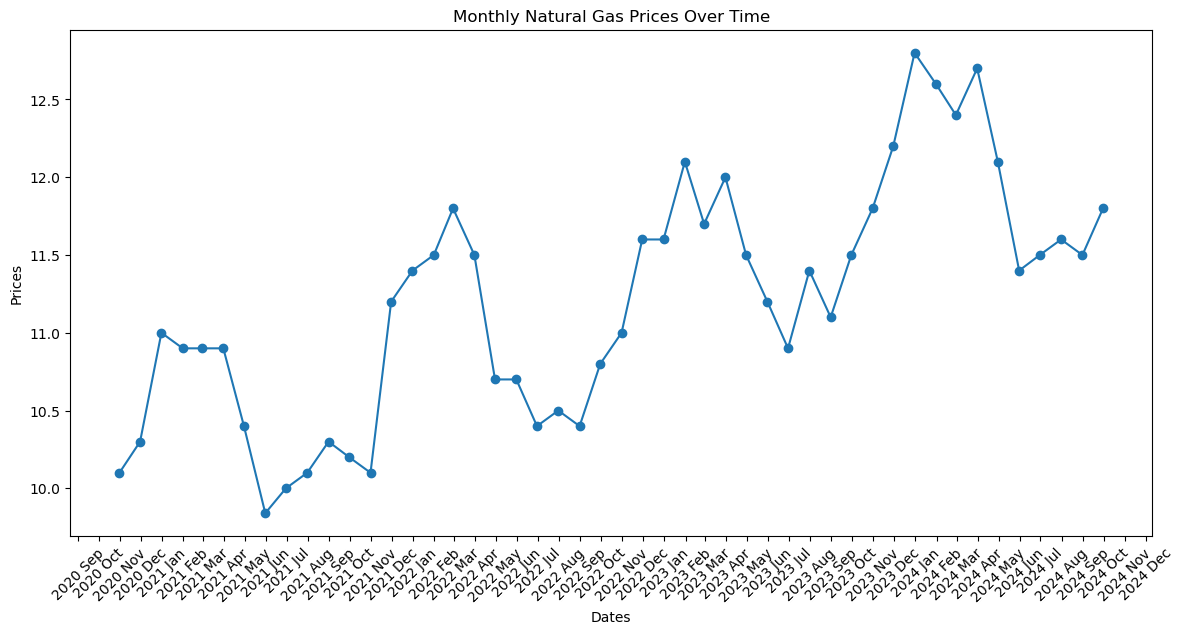

In [3]:
#Run Visualisations to get a better understanding of seasonal trends 
#1. Line Plot of the entire time series 
plt.figure(figsize=(12,6))
plt.plot(nat_gas['Dates'], nat_gas['Prices'], marker='o', linestyle='-')
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y %b'))
plt.title('Monthly Natural Gas Prices Over Time')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.grid = True
plt.tight_layout()
plt.xticks(rotation=45)  # Rotate x-axis labels to avoid overlap
plt.show()

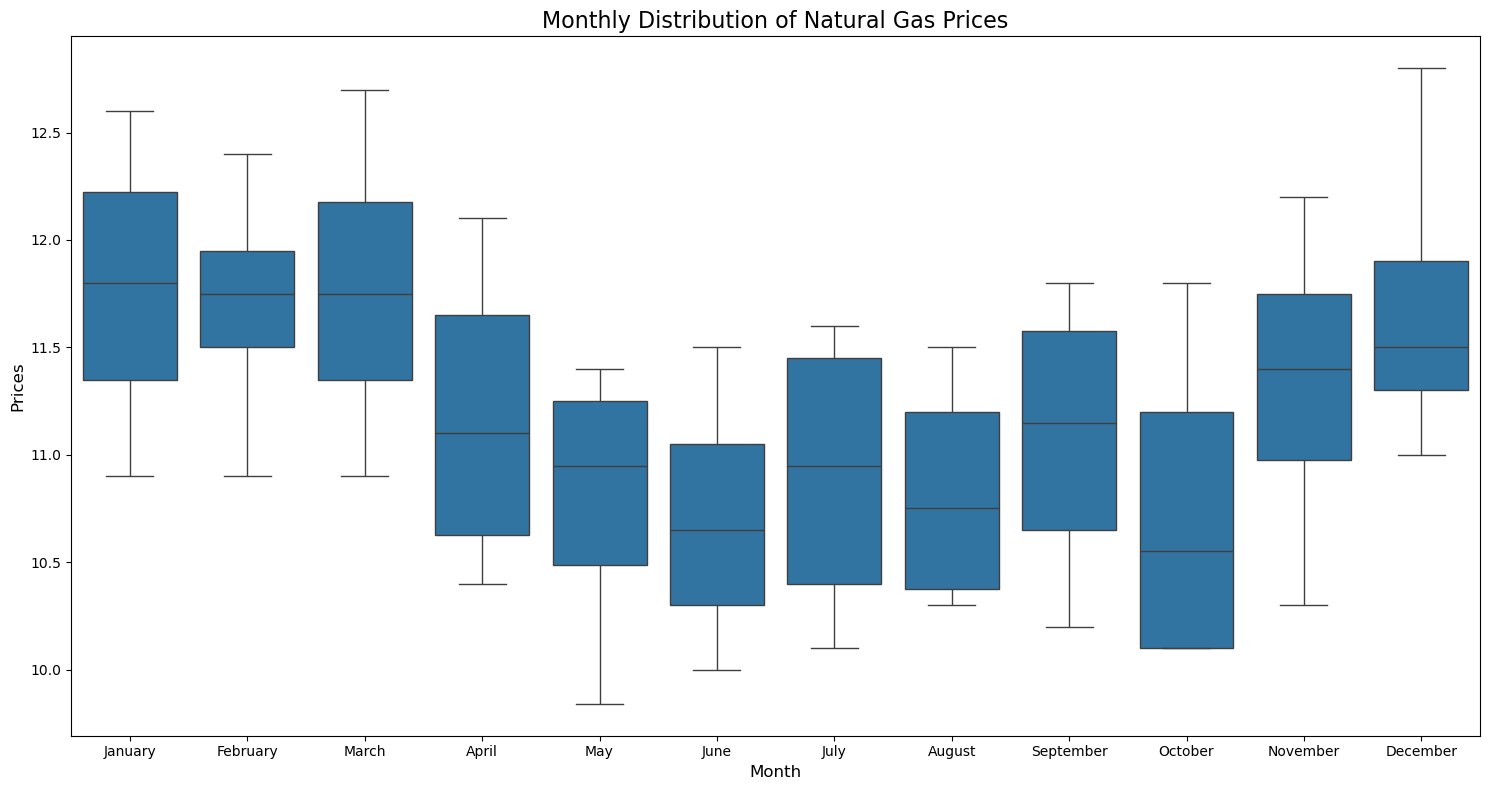

In [4]:
#Extract Month and Year for Grouping 
nat_gas['month'] = nat_gas['Dates'].dt.month
nat_gas['year'] = nat_gas['Dates'].dt.year
nat_gas['month_name'] = nat_gas['Dates'].dt.month_name()
nat_gas['month_year'] = nat_gas['Dates'].dt.strftime('%b-%Y')

#Create the Box Plot
plt.figure(figsize=(15,8))
ax = sns.boxplot(x='month_name', y='Prices', data=nat_gas,
                 order= ['January', 'February', 'March', 'April', 'May', 'June', 
                       'July', 'August', 'September', 'October', 'November', 'December'])
plt.title ('Monthly Distribution of Natural Gas Prices', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Prices', fontsize=12)
plt.tight_layout()
plt.show()
#There is a clear justification to buy natural gas in the summer months and sell gas in the winter. 

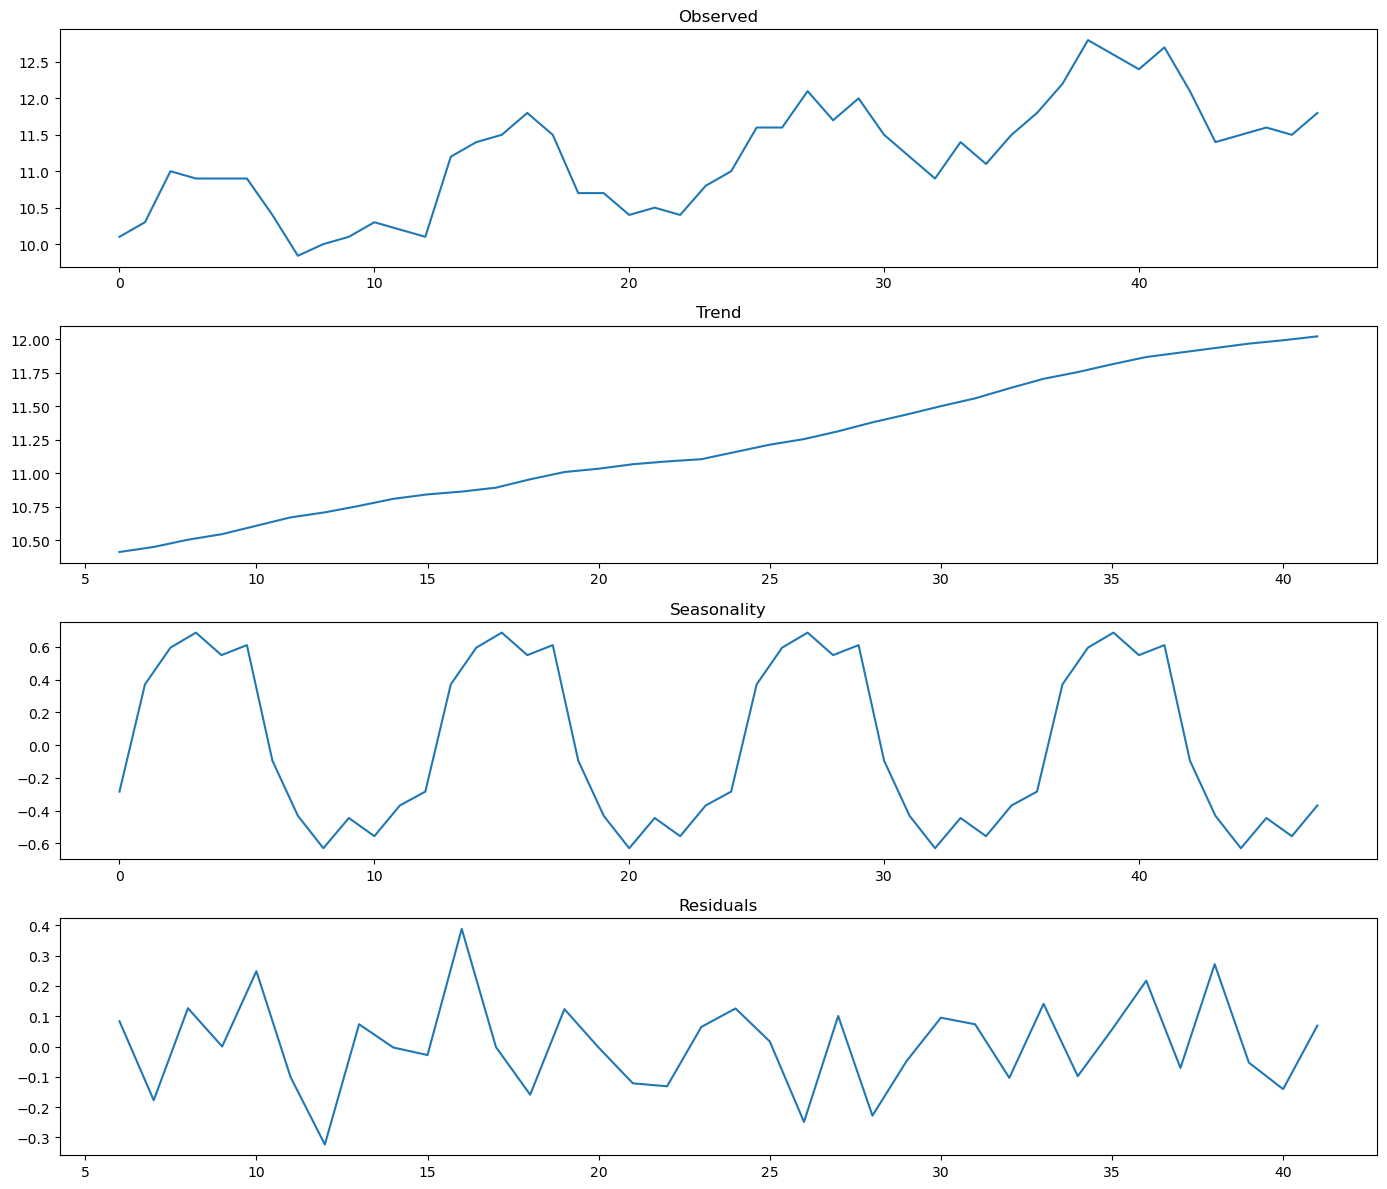

In [5]:
#Decompose the time series to understand patterns 
decomposition = seasonal_decompose(nat_gas['Prices'], model = 'additive', period =12)
fig, (ax1, ax2, ax3, ax4)= plt.subplots(4,1,figsize=(14,12))
decomposition.observed.plot(ax=ax1, title='Observed')
decomposition.trend.plot(ax=ax2, title='Trend')
decomposition.seasonal.plot(ax=ax3, title='Seasonality')
decomposition.resid.plot(ax=ax4, title='Residuals')
plt.tight_layout()
plt.grid = True
plt.show()
                         

In [6]:
#SARIMA
#1. Stationarize the Data 
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    print ('Null Hypothesis: Unit Root Present')
    print ('Test Statistic < Critical Value => Reject Null')
    print ('P-Value =< Alpha(0.5) => Reject Null\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput[f'Critical Value {key}']=value
    print (dfoutput, '\n')

def kpss_test(timeseries, regression='c'):
    print ('Results of KPSS Test:')
    print ("Null Hypothesis: Data is Stationary/Trend Stationary")
    print ('Test Statistic > Critical Value => Reject Null')
    print ('P-Value =< Alpha(0.5) => Reject Null\n')
    kpsstest = kpss(timeseries, regression= regression)
    kpss_output = pd.Series(kpsstest[0:3], index = ['Test Statistic', 'p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output[f'Critical Value {key}']=value
    print (kpss_output, '\n')

<Axes: xlabel='Dates'>

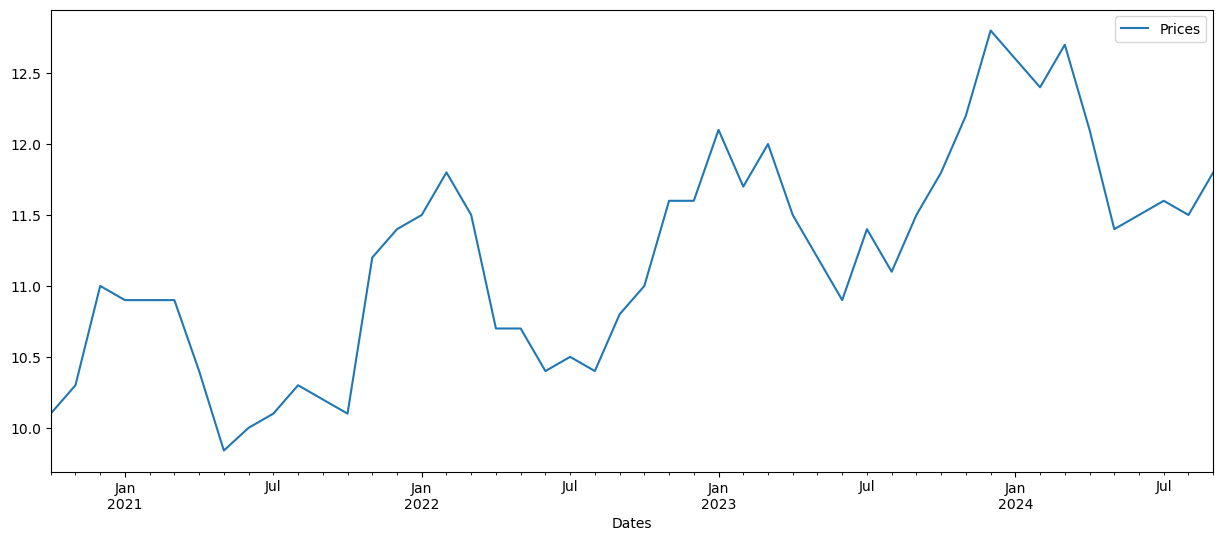

In [7]:
price_df = pd.DataFrame(nat_gas['Prices'])
price_df.index = nat_gas['Dates']
price_df.index.freq = 'ME'
price_df.plot(figsize=(15,6))

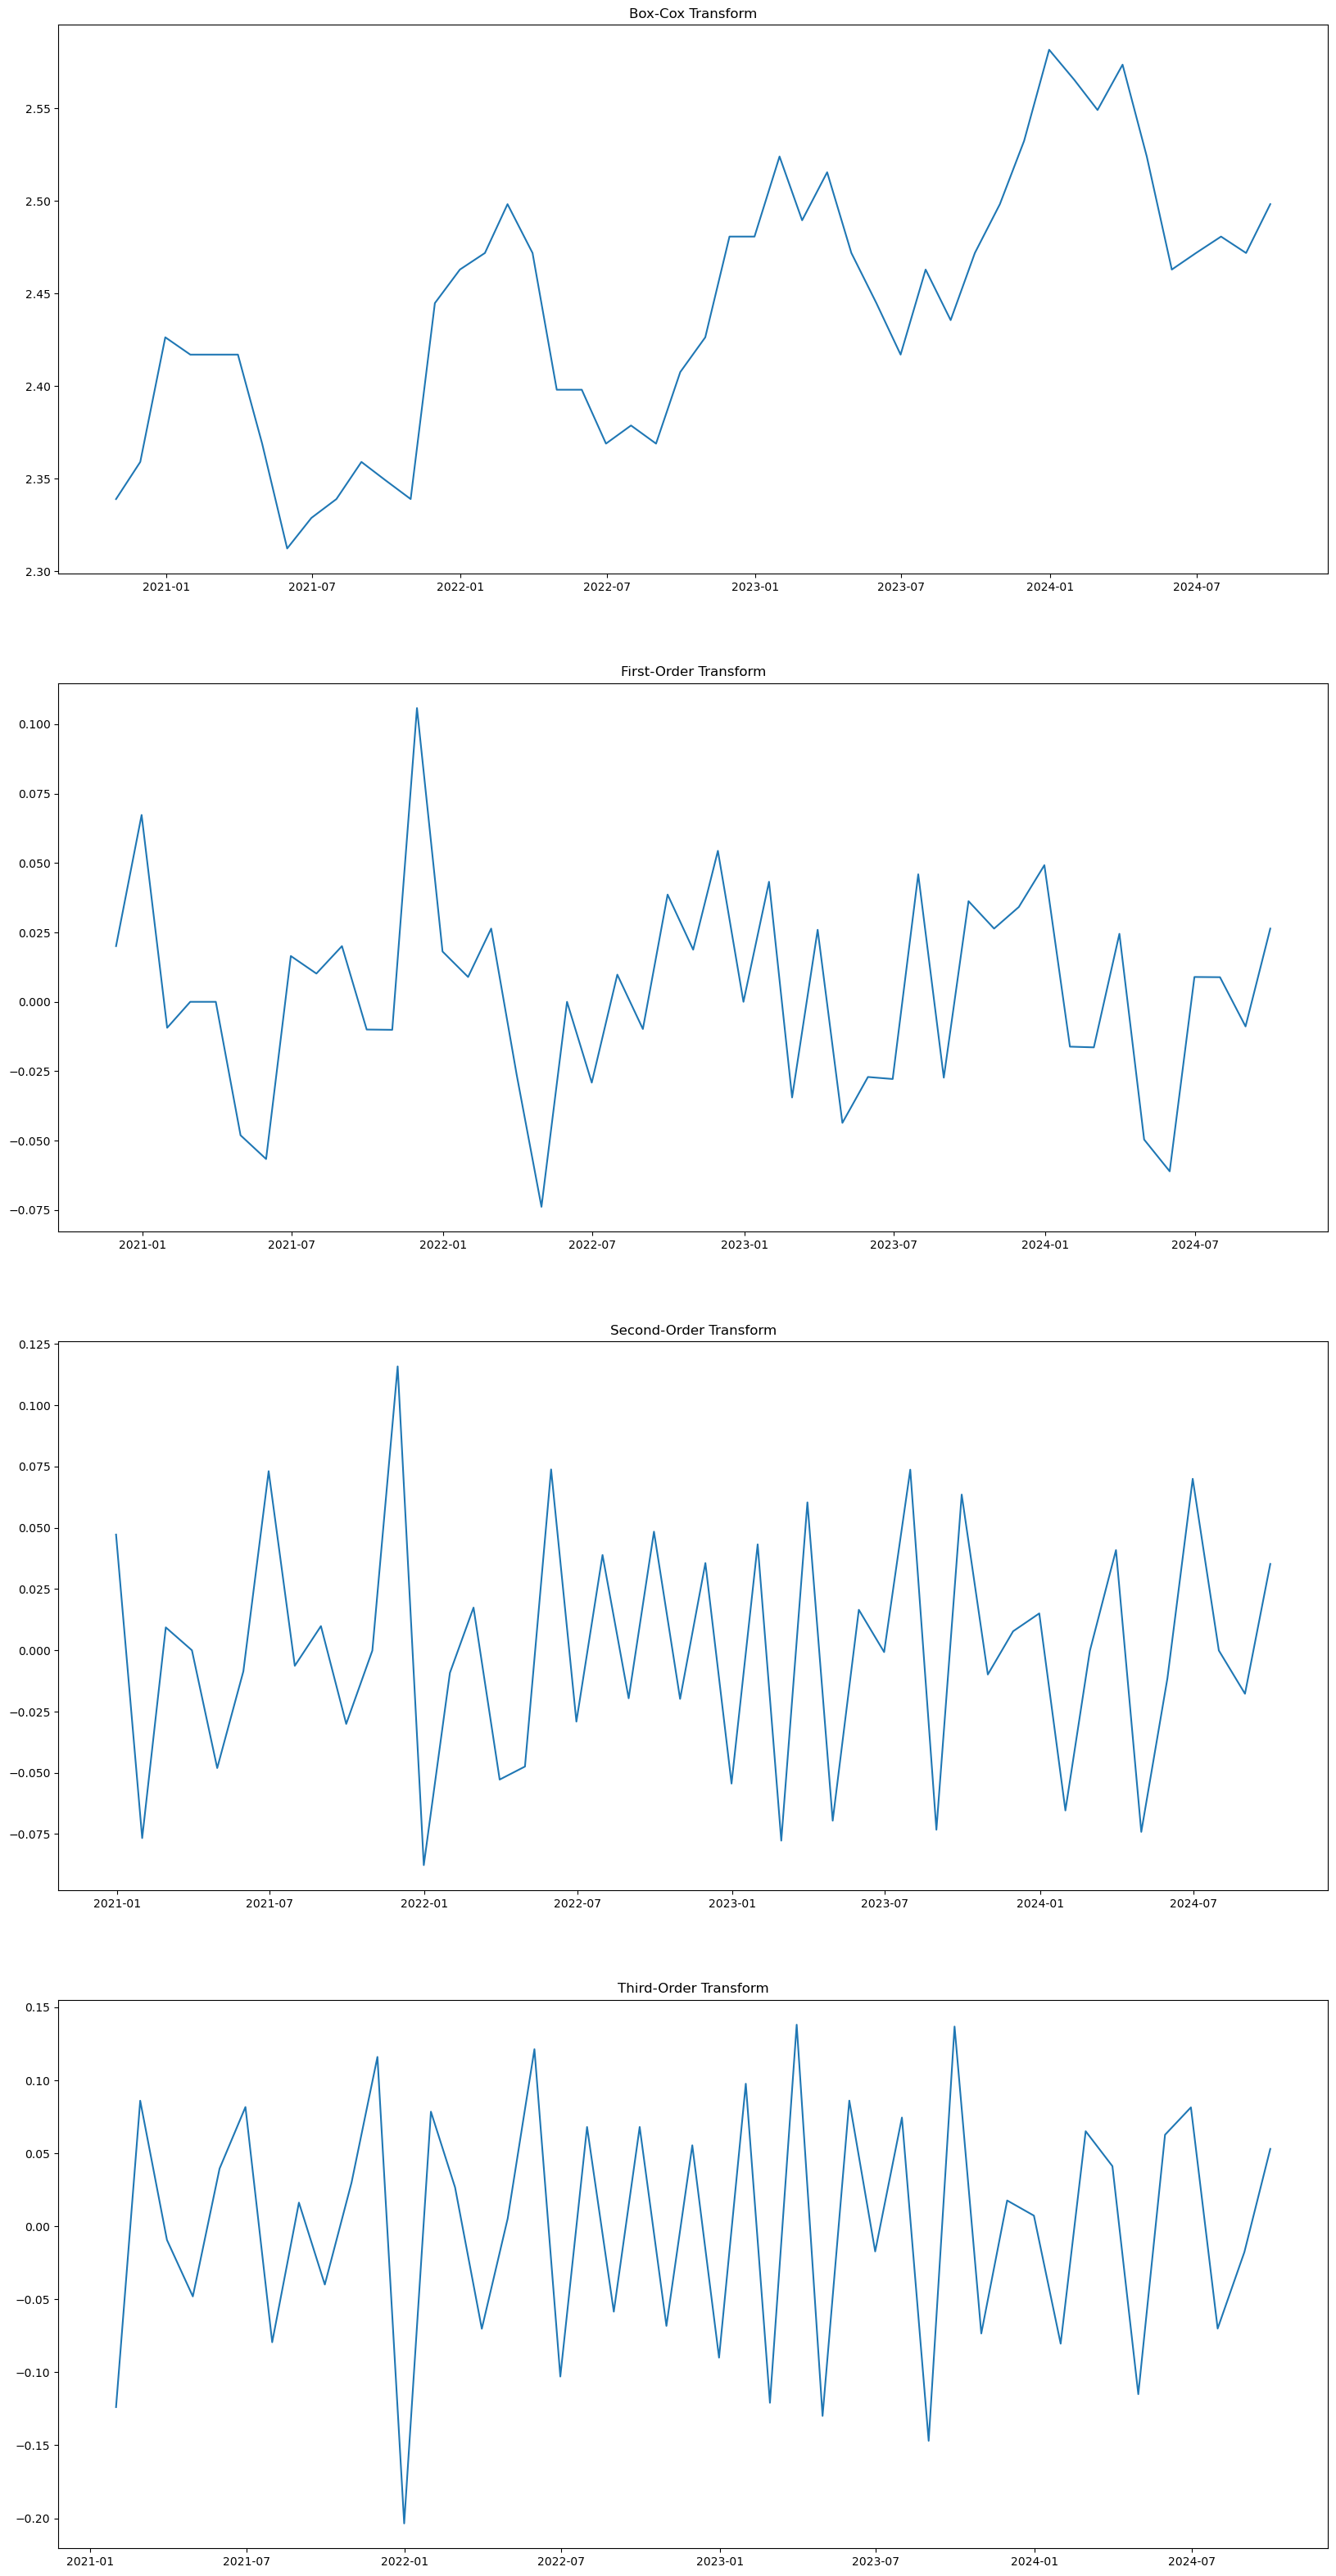

Unit Root Tests:
BoxCox-No Difference
Results of Dickey-Fuller Test:
Null Hypothesis: Unit Root Present
Test Statistic < Critical Value => Reject Null
P-Value =< Alpha(0.5) => Reject Null

Test Statistic                 -0.047074
p-value                         0.954462
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value 1%              -3.620918
Critical Value 5%              -2.943539
Critical Value 10%             -2.610400
dtype: float64 

Results of KPSS Test:
Null Hypothesis: Data is Stationary/Trend Stationary
Test Statistic > Critical Value => Reject Null
P-Value =< Alpha(0.5) => Reject Null

Test Statistic         0.735453
p-value                0.010322
Lags Used              4.000000
Critical Value 10%     0.347000
Critical Value 5%      0.463000
Critical Value 2.5%    0.574000
Critical Value 1%      0.739000
dtype: float64 


First Difference
Results of Dickey-Fuller Test:
Null Hypothesis: Unit Root Present
Test Statistic < Criti

In [8]:
price_df['bc_price'], lamb = boxcox(price_df.Prices)
price_df['d1_price'] = price_df['bc_price'].diff()
price_df['d2_price'] = price_df['d1_price'].diff()
price_df['d3_price'] = price_df['d2_price'].diff()
fig = plt.figure(figsize=(20,40))

plt_bc = plt.subplot(411)
plt_bc.plot(price_df.bc_price)
plt_bc.title.set_text('Box-Cox Transform')
plt_d1 = plt.subplot(412)
plt_d1.plot(price_df.d1_price)
plt_d1.title.set_text('First-Order Transform')
plt_d2 = plt.subplot(413)
plt_d2.plot(price_df.d2_price)
plt_d2.title.set_text('Second-Order Transform')
plt_d3 = plt.subplot(414)
plt_d3.plot(price_df.d3_price)
plt_d3.title.set_text('Third-Order Transform')
plt.show()



print ('Unit Root Tests:')
print ('BoxCox-No Difference')
adf_test(price_df.bc_price)
kpss_test(price_df.bc_price)
print ('\nFirst Difference')
adf_test(price_df.d1_price.dropna())
kpss_test(price_df.d1_price.dropna())
print ('\nSecond Difference')
adf_test(price_df.d2_price.dropna())
kpss_test(price_df.d2_price.dropna())
print ('\nThird Difference')
adf_test(price_df.d3_price.dropna())
kpss_test(price_df.d3_price.dropna())

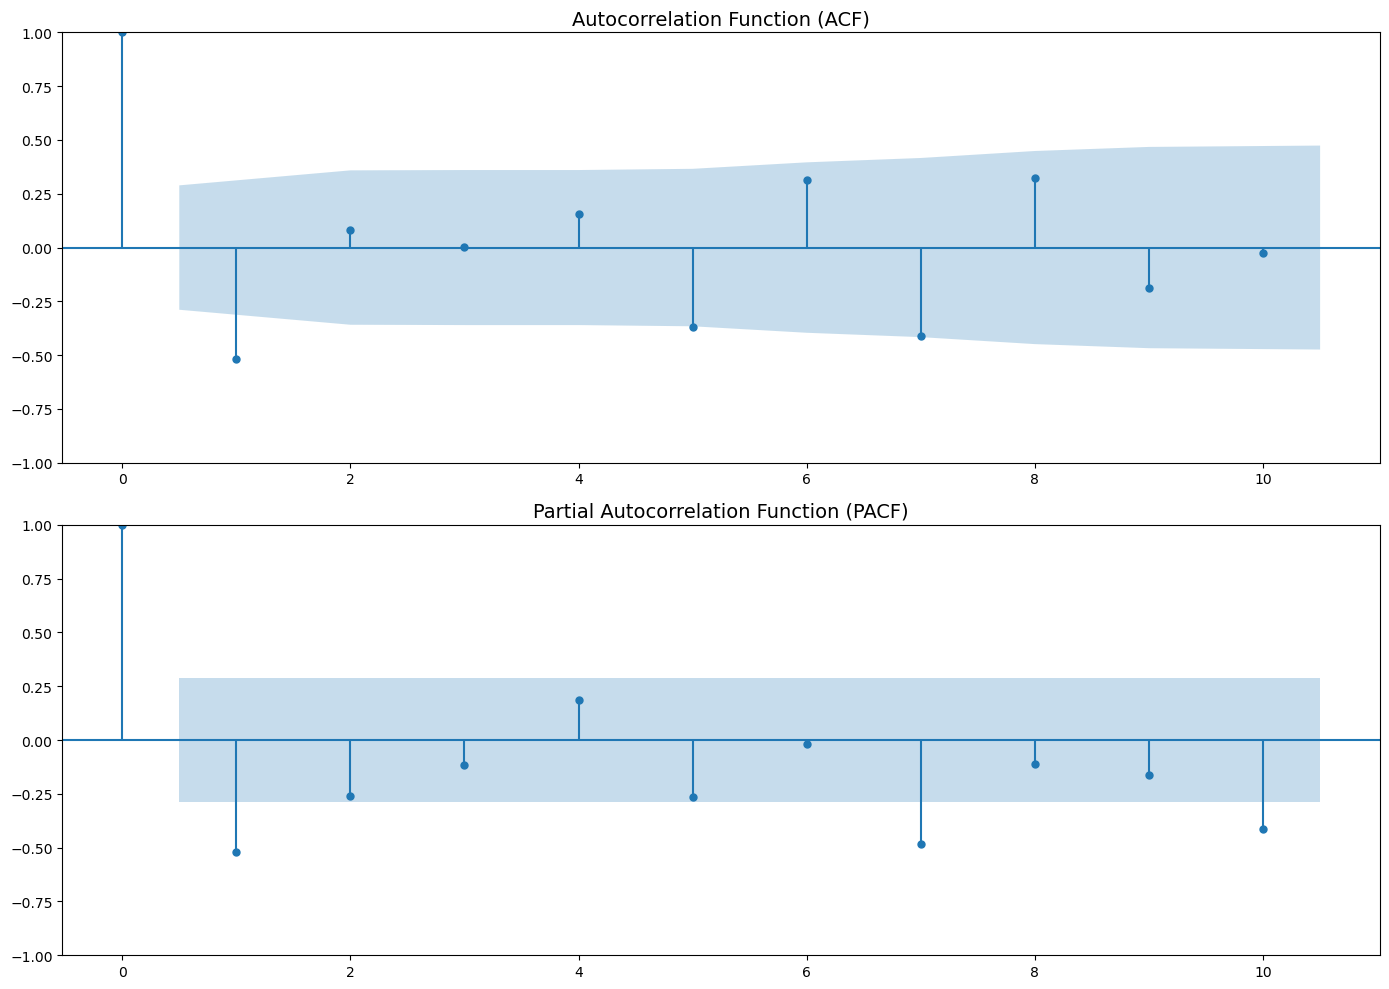

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,10))
plot_acf(price_df['d2_price'].dropna(),lags=10,  ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)', fontsize= 14)
plot_pacf(price_df['d2_price'].dropna(), lags=10, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)', fontsize=14)
plt.tight_layout()
plt.show()


In [10]:
#Fit SARIMA model to extrapolate prices out 1 year
s_model = SARIMAX(price_df['bc_price'],
                  seasonal_order=(1,2,0,12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
model_fit=s_model.fit(disp=False)
#Print model summary
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           bc_price   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(1, 2, 0, 12)   Log Likelihood                  24.082
Date:                            Wed, 24 Sep 2025   AIC                            -42.164
Time:                                    16:04:58   BIC                            -40.971
Sample:                                10-31-2020   HQIC                           -42.917
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5345      0.366     -1.459      0.145      -1.252       0.183
ar.S.L12      -0.8982      0.233   

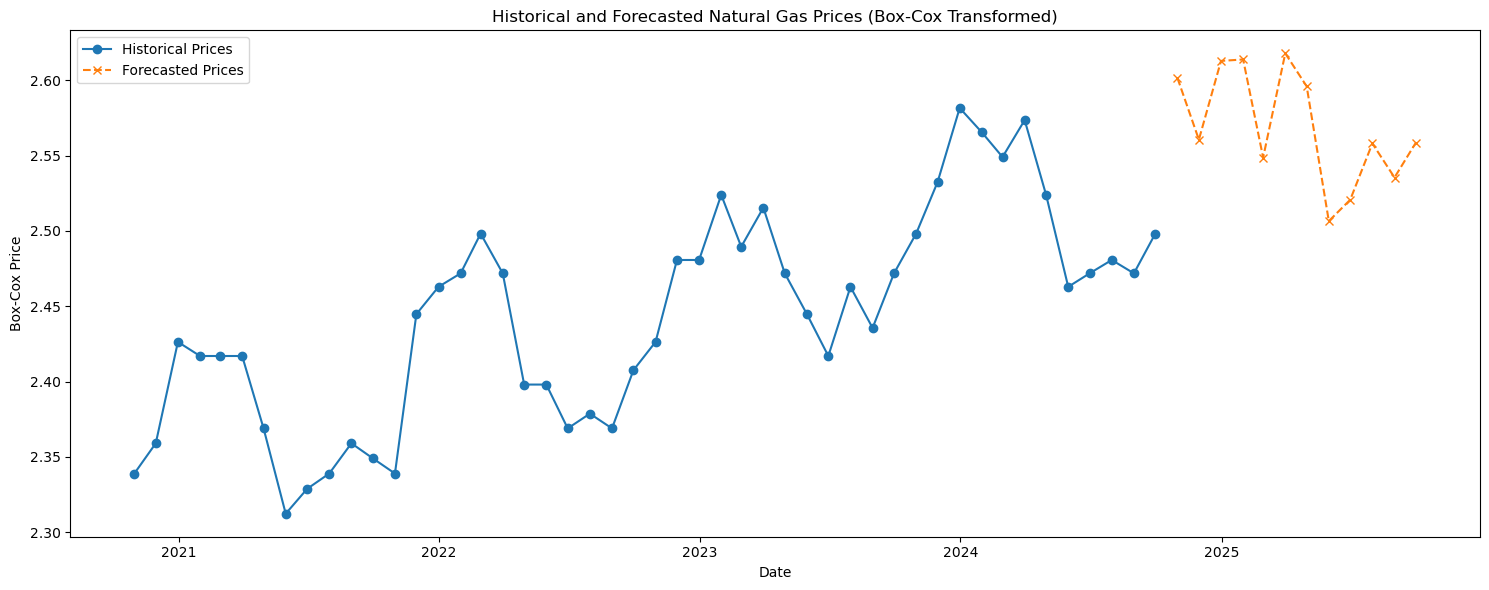

In [11]:
#Extrapolation and Forecasting
#Get forecast 12 months into the future
n_periods = 12
forecast = model_fit.get_forecast(steps=n_periods)
forecast_values = forecast.predicted_mean

#Create future dates
last_date = price_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_periods, freq='M')

#combine historical and forecasted data
forecast_df = pd.DataFrame({'Dates': future_dates, 'Forecasted_Prices': forecast_values})
forecast_df.set_index('Dates', inplace=True)

#Plot historical and forecasted prices
plt.figure(figsize=(15,6))
plt.plot(price_df.index, price_df['bc_price'], label='Historical Prices', marker='o')
plt.plot(forecast_df.index, forecast_df['Forecasted_Prices'], label='Forecasted Prices', marker='x', linestyle='--')
plt.title('Historical and Forecasted Natural Gas Prices (Box-Cox Transformed)')
plt.xlabel('Date')
plt.ylabel('Box-Cox Price')
plt.legend()
plt.tight_layout()
plt.show()

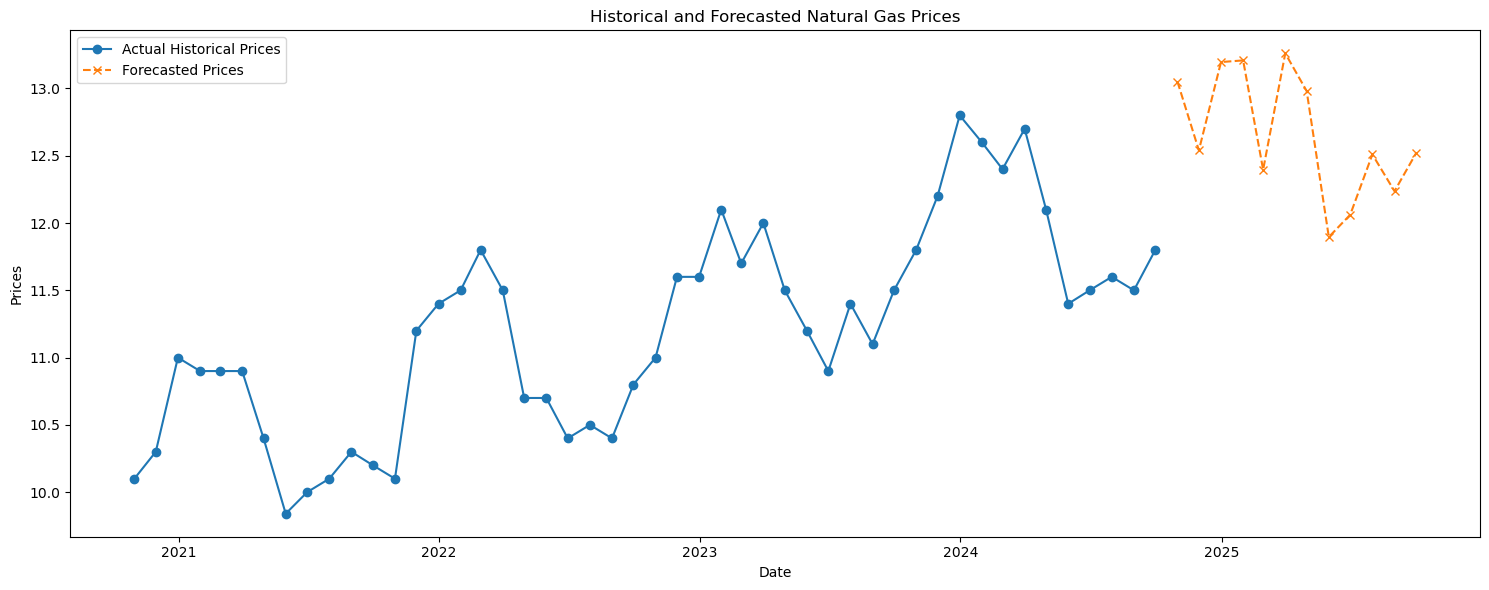

In [12]:
actual_forecast = inv_boxcox(forecast_values, lamb)

#combine historical and forecasted data
actual_forecast_df = pd.DataFrame({'Dates': future_dates, 'Forecasted_Prices': actual_forecast})
actual_forecast_df.set_index('Dates', inplace=True)

plt.figure (figsize=(15,6))
plt.plot(price_df.index, price_df['Prices'], label='Actual Historical Prices', marker='o')
plt.plot(actual_forecast_df.index, actual_forecast, label='Forecasted Prices', marker='x', linestyle='--')
plt.title('Historical and Forecasted Natural Gas Prices')  
plt.xlabel('Date')
plt.ylabel('Prices')   
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
def get_price (price_df):
    user_date = input ("Enter an end of month date (YYYY-MM-DD) to get the forecasted price: ")
    try:
        date = pd.to_datetime(user_date)
        price = actual_forecast_df.loc[date, 'Forecasted_Prices']
        print (f'The forecasted price for {date.strftime("%B %Y")} is: ${price:.2f}')
    except KeyError:
        print ("Date not in forecast range. Please enter a date within the next 12 months.")

get_price(price_df) 


The forecasted price for January 2025 is: $13.21
